 <h1>EDA: Advanced Feature Extraction.

In [29]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
# Fix for UnicodeDecodeError:
# Using encoding='latin-1' allows reading CSV files that contain non-UTF8 characters.
# More details: https://stackoverflow.com/questions/12468179

# Check if the preprocessed CSV file already exists.
if os.path.isfile('df_fe_without_preprocessing_train.csv'):

    # Read the file using latin-1 encoding (avoids decode errors)
    df = pd.read_csv("df_fe_without_preprocessing_train.csv", encoding='latin-1')

    # Replace all NaN values with empty strings
    df = df.fillna('')

    # Display first rows to confirm successful loading
    print(df.head(2))

else:
    # If the file does not exist, notify the user
    print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")


   id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   

   freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  word_Total  \
0          1     66     57          14          12         10.0        23.0   
1          1     51     88           8          13          4.0        20.0   

   word_share  freq_q1+q2  freq_q1-q2  
0    0.434783           2           0  
1    0.200000           5           3  


<h2>Preprocessing of Text

Preprocessing:
Removing html tags
Removing Punctuations
Performing stemming
Removing Stopwords
Expanding contractions etc.

In [35]:
# SAFE_DIV is used to avoid division-by-zero errors (common in ML feature calculations)
SAFE_DIV = 0.0001

# Load standard English stop words from NLTK
STOP_WORDS = stopwords.words("english")


# -----------------------------------------------------------
# preprocess(x)
# Cleans and normalizes a text string.
# Steps:
#   1. lowercase
#   2. expand contractions (can't → can not)
#   3. standardize currency/symbol formats
#   4. convert 1000000 → 1m and 1000 → 1k
#   5. remove non-alphanumeric characters
#   6. apply Porter stemming
#   7. remove HTML tags via BeautifulSoup
# -----------------------------------------------------------
def preprocess(x):
    # Convert to string and lowercase everything
    x = str(x).lower()

    # Replace common large-number formats and normalize contractions
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'") \
         .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not") \
         .replace("n't", " not").replace("what's", "what is").replace("it's", "it is") \
         .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are") \
         .replace("he's", "he is").replace("she's", "she is").replace("'s", " own") \
         .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ") \
         .replace("€", " euro ").replace("'ll", " will")

    # Convert large numeric patterns using regex
    # 10000000 → 10m
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    # 10000 → 10k
    x = re.sub(r"([0-9]+)000", r"\1k", x)

    # Initialize porter stemmer
    porter = PorterStemmer()

    # Pattern to remove non-word characters (punctuation, symbols)
    pattern = re.compile('\W')

    # Replace all non-alphanumeric characters with a space
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)

    # Apply stemming + remove HTML tags if any
    if type(x) == type(''):
        x = porter.stem(x)           # Reduce words to their root form
        example1 = BeautifulSoup(x)  # Remove HTML markup
        x = example1.get_text()

    return x


<h2>Advanced Feature Extraction (NLP and Fuzzy Features)

Definition:

Token: You get a token by splitting sentence a space
Stop_Word : stop words as per NLTK.
Word : A token that is not a stop_word
Features:

cwc_min : Ratio of common_word_count to min lenghth of word count of Q1 and Q2
cwc_min = common_word_count / (min(len(q1_words), len(q2_words))


- __cwc_max__ : Ratio of common_word_count to max lenghth of word count of Q1 and Q2
cwc_max = common_word_count / (max(len(q1_words), len(q2_words))

- __csc_min__ : Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2
csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))

- __csc_max__ : Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2
csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))

- __ctc_min__ : Ratio of common_token_count to min lenghth of token count of Q1 and Q2
ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))

ctc_max : Ratio of common_token_count to max lenghth of token count of Q1 and Q2
ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))


last_word_eq : Check if First word of both questions is equal or not
last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])


first_word_eq : Check if First word of both questions is equal or not
first_word_eq = int(q1_tokens[0] == q2_tokens[0])


abs_len_diff : Abs. length difference
abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))


mean_len : Average Token Length of both Questions
mean_len = (len(q1_tokens) + len(q2_tokens))/2


fuzz_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


fuzz_partial_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


token_sort_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


token_set_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


longest_substr_ratio : Ratio of length longest common substring to min lenghth of token count of Q1 and Q2
longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

In [36]:
# -----------------------------------------------
# TOKEN-LEVEL SIMILARITY FEATURES
# -----------------------------------------------
def get_token_features(q1, q2):
    """
    Extract 10 token-based similarity features between two preprocessed questions.
    Features capture:
      – Word overlap (stopwords & non-stopwords)
      – Token overlap ratios
      – First/last word match
      – Length differences
    """

    token_features = [0.0] * 10

    # Split into tokens (already lowercased & cleaned in preprocessing)
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    # If either question is empty → return zeros
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Separate stopwords and non-stopwords
    q1_words = set([w for w in q1_tokens if w not in STOP_WORDS])
    q2_words = set([w for w in q2_tokens if w not in STOP_WORDS])

    q1_stops = set([w for w in q1_tokens if w in STOP_WORDS])
    q2_stops = set([w for w in q2_tokens if w in STOP_WORDS])

    # Compute common word, stopword, and token counts
    common_word_count  = len(q1_words.intersection(q2_words))
    common_stop_count  = len(q1_stops.intersection(q2_stops))
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

    # Overlap ratios (min/max denominators avoid bias toward longer sentences)
    token_features[0] = common_word_count  / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count  / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count  / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count  / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

    # First and last word match → signals strong structural similarity
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    token_features[7] = int(q1_tokens[0]  == q2_tokens[0])

    # Length difference and mean length
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    token_features[9] = (len(q1_tokens) + len(q2_tokens)) / 2

    return token_features


# -----------------------------------------------
# LONGEST COMMON SUBSTRING FEATURE
# -----------------------------------------------
def get_longest_substr_ratio(a, b):
    """
    Computes length of the longest common substring (LCS)
    normalized by the smaller string length.
    Captures deep structural similarity not detected by token methods.
    """
    substrings = list(distance.lcsubstrings(a, b))
    if len(substrings) == 0:
        return 0
    return len(substrings[0]) / (min(len(a), len(b)) + 1)


# -----------------------------------------------
# MAIN FEATURE EXTRACTION PIPELINE
# -----------------------------------------------
def extract_features(df):
    """
    Applies preprocessing and computes all engineered features:
    – Token-level features (10)
    – Fuzzy string similarity features (4)
    – Longest common substring ratio
    Total new features added: 15+
    """

    # Preprocess text fields
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("Extracting token features...")

    # Generate token features for each row
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)

    # Expand the 10-token feature list into dedicated columns
    df["cwc_min"]       = [x[0] for x in token_features]
    df["cwc_max"]       = [x[1] for x in token_features]
    df["csc_min"]       = [x[2] for x in token_features]
    df["csc_max"]       = [x[3] for x in token_features]
    df["ctc_min"]       = [x[4] for x in token_features]
    df["ctc_max"]       = [x[5] for x in token_features]
    df["last_word_eq"]  = [x[6] for x in token_features]
    df["first_word_eq"] = [x[7] for x in token_features]
    df["abs_len_diff"]  = [x[8] for x in token_features]
    df["mean_len"]      = [x[9] for x in token_features]

    print("Extracting fuzzy similarity features...")

    # Fuzzy string similarity metrics (excellent for noisy text)
    df["token_set_ratio"]      = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    df["token_sort_ratio"]     = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]           = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]   = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)

    # Structural similarity via longest common substring
    df["longest_substr_ratio"] = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)

    return df


In [37]:
# ------------------------------------------------------------
# Load NLP features if already saved, otherwise compute them
# ------------------------------------------------------------

# Check if the precomputed NLP-feature CSV exists
if os.path.isfile('nlp_features_train.csv'):

    # Load saved feature file (faster than recomputing)
    df = pd.read_csv("nlp_features_train.csv", encoding='latin-1')

    # Replace NaN values (important for text processing consistency)
    df.fillna('')

else:
    # If file does not exist → extract features from raw train.csv
    print("Extracting features for train:")

    # Load original training dataset
    df = pd.read_csv("train.csv")

    # Generate all NLP-based engineered features
    df = extract_features(df)

    # Save new feature file so next time it loads instantly
    df.to_csv("nlp_features_train.csv", index=False)

# Show first 2 rows to verify everything loaded correctly
df.head(2)


Extracting features for train:
Extracting token features...
Extracting fuzzy similarity features...


,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


<h2>Analysis of extracted features

Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
We can observe the most frequent occuring words

In [43]:
# ------------------------------------------------------------
# Separate duplicate and non-duplicate question pairs
# ------------------------------------------------------------
df_duplicate     = df[df['is_duplicate'] == 1]   # All positive pairs (duplicate questions)
df_nonduplicate  = df[df['is_duplicate'] == 0]   # All negative pairs (non-duplicate questions)

# ------------------------------------------------------------
# Flatten question pairs into a 1-D list
# Each row has (question1, question2)
# dstack + flatten turns:
#   [[q1, q2],
#    [q1, q2], ...]
# INTO:
#   [q1, q2, q1, q2, q1, q2, ...]
# ------------------------------------------------------------
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([df_nonduplicate["question1"], df_nonduplicate["question2"]]).flatten()

print("Number of data points in class 1 (duplicate pairs) :", len(p))
print("Number of data points in class 0 (non duplicate pairs) :", len(n))

# ------------------------------------------------------------
# Save both flattened arrays to text files
# Each line contains one question string
# Useful for training word embeddings / NLP models separately
# ------------------------------------------------------------
np.savetxt("train_p.txt", p, fmt="%s", encoding="utf-8")
np.savetxt("train_n.txt", n, fmt="%s", encoding="utf-8")


Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [44]:
# ------------------------------------------------------------
# Read the saved text files and remove unwanted stopwords
# ------------------------------------------------------------

from os import path

d = path.dirname('.')   # current directory

# Read text files (force UTF-8 to avoid decoding errors)
textp_w = open(path.join(d, 'train_p.txt'), encoding="latin-1").read()
textn_w = open(path.join(d, 'train_n.txt'), encoding="latin-1").read()


# Load wordcloud stopwords and modify the list
stopwords = set(STOPWORDS)

# Add extra unwanted tokens
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")     # remove blank spaces

# Remove useful words from stopword list (so they are counted)
# Use discard() instead of remove() to avoid KeyError
stopwords.discard("not")
stopwords.discard("no")
stopwords.discard("like")

print("Total number of characters in duplicate questions :", len(textp_w))
print("Total number of characters in non-duplicate questions :", len(textn_w))


Total number of characters in duplicate questions : 16110763
Total number of characters in non-duplicate questions : 33201039


Word Clouds generated from duplicate pair question's text __

Word Cloud for Duplicate Question Pairs


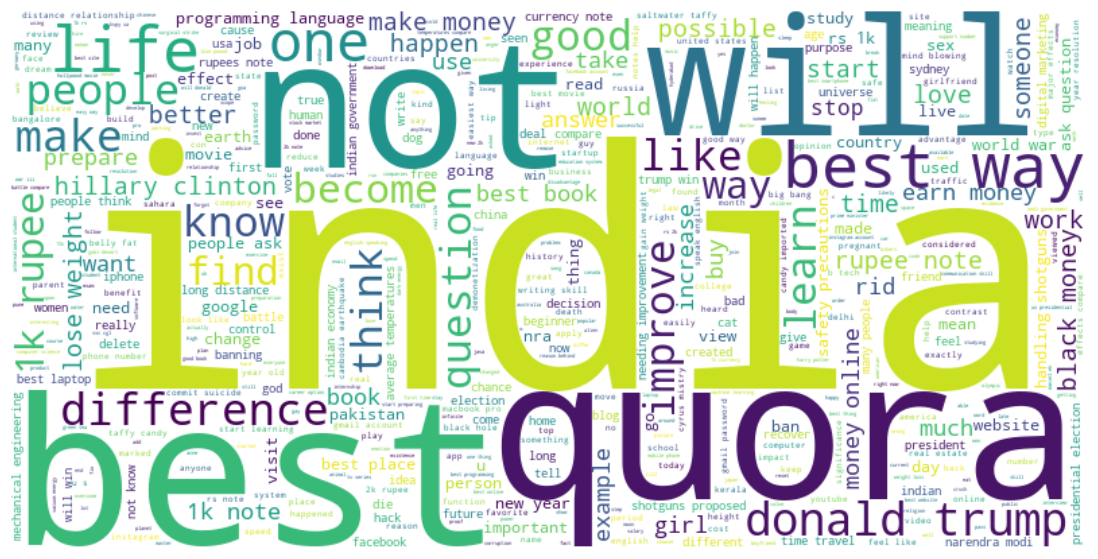

In [45]:
# ------------------------------------------------------------
# WordCloud for Duplicate Question Pairs
# ------------------------------------------------------------

# Create a WordCloud object
# background_color  : white background
# max_words         : maximum number of words allowed in the cloud
# stopwords         : words to ignore (you customized earlier)
wc = WordCloud(
    background_color="white",
    max_words=500,          # safer than using len(textp_w), avoids performance issues
    stopwords=stopwords,
    width=800,
    height=400
)

# Generate word cloud from the combined duplicate question text
wc.generate(textp_w)

# Display result
print("Word Cloud for Duplicate Question Pairs")
plt.figure(figsize=(15, 7))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


Word Cloud for non-Duplicate Question pairs:


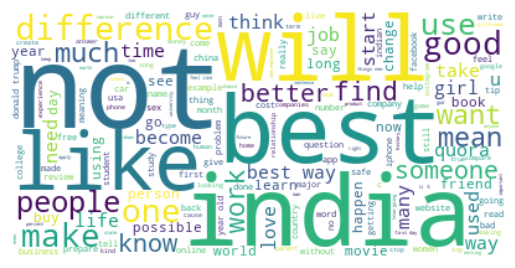

In [46]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

< h2>Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']

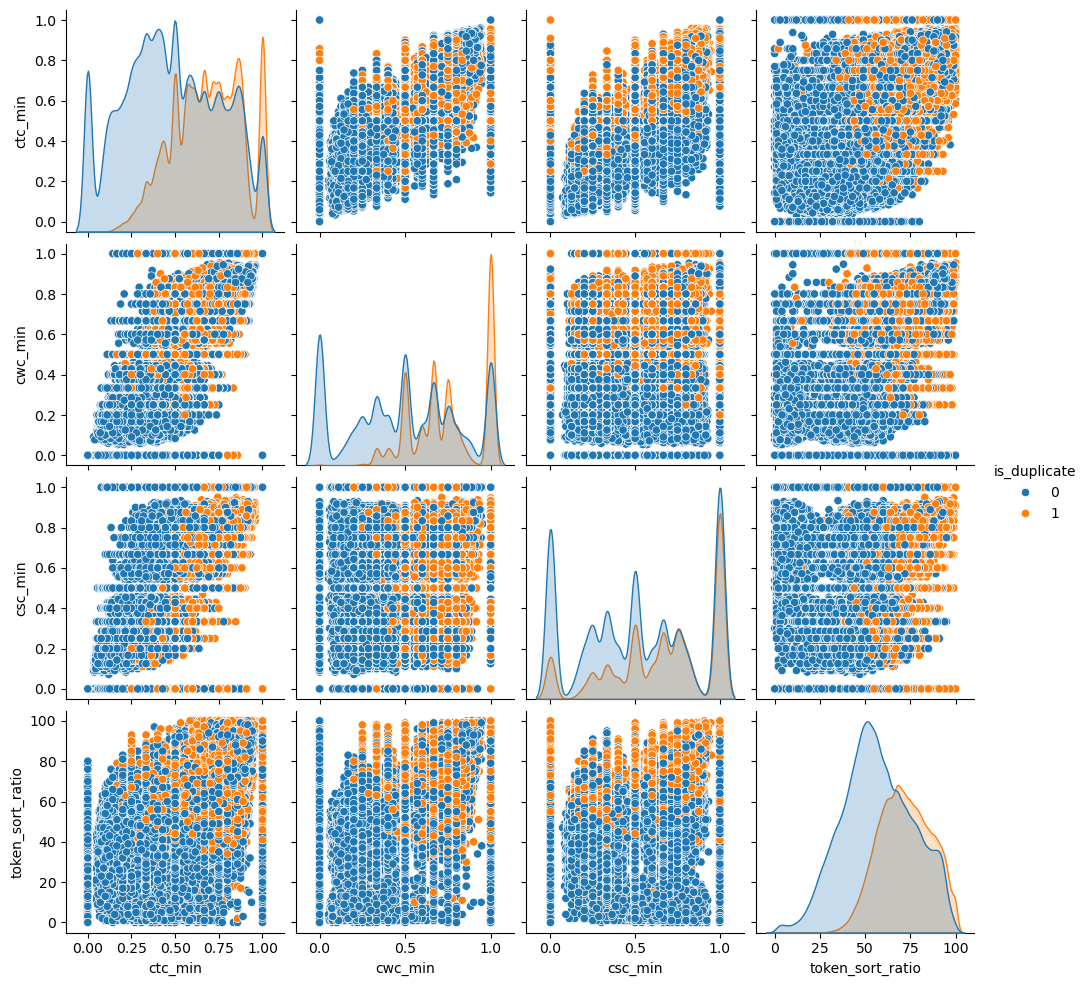

In [47]:
# ------------------------------------------------------------
# Visualizing Feature Interactions Using Pairplot
# ------------------------------------------------------------

# Total number of rows in the dataset
n = df.shape[0]

# Create pairwise scatter plots for selected features
# Features visualized:
#   - ctc_min      → common token count (min-normalized)
#   - cwc_min      → common word count (min-normalized)
#   - csc_min      → common stopword count (min-normalized)
#   - token_sort_ratio → fuzzy string similarity feature
#
# 'hue=is_duplicate' colors points based on class:
#   1 → duplicate question pair (positive class)
#   0 → non-duplicate (negative class)
#
# Pairplot helps identify:
#   - feature separability between classes
#   - correlation structure
#   - potential decision boundaries
sns.pairplot(
    df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n],
    hue='is_duplicate',
    vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']
)

# Show the plot
plt.show()


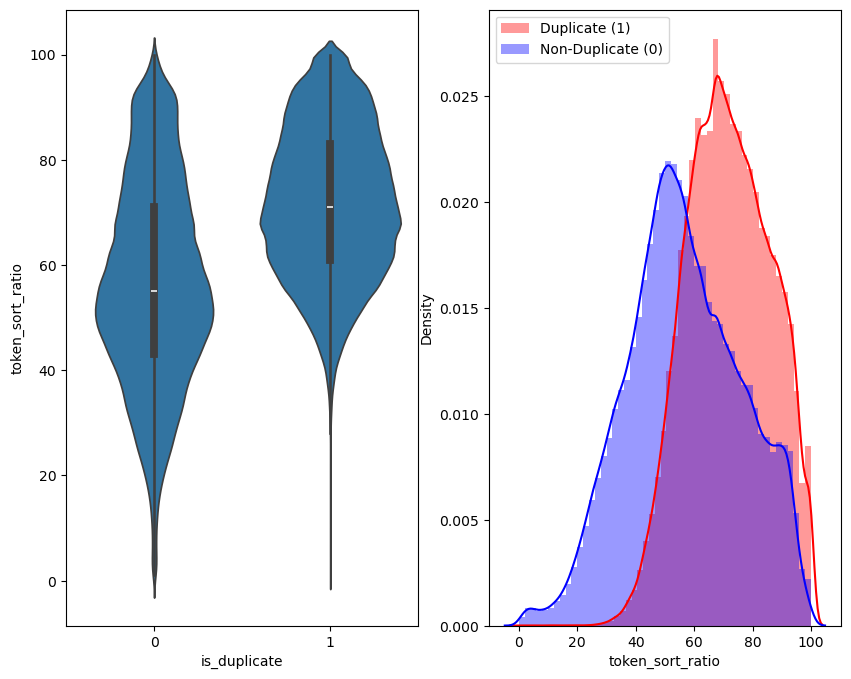

In [48]:
# ------------------------------------------------------------
# Distribution of the token_sort_ratio feature
# ------------------------------------------------------------
plt.figure(figsize=(10, 8))

# ---------------------- Violin Plot -------------------------
# Visualizes the distribution of token_sort_ratio for:
#   is_duplicate = 1 (duplicate question pairs)
#   is_duplicate = 0 (non-duplicate question pairs)
#
# Violin plots show density + distribution shape → useful to see
# how well this feature separates the two classes.
plt.subplot(1, 2, 1)
sns.violinplot(
    x='is_duplicate',
    y='token_sort_ratio',
    data=df[0:]
)

# ---------------------- Distribution Plot -------------------
# Overlays the probability distribution (KDE + histogram)
# for duplicate (red) and non-duplicate (blue) pairs.
#
# token_sort_ratio is a fuzzy string similarity measure.
# Higher values → more similar text after sorting tokens.
plt.subplot(1, 2, 2)
sns.distplot(
    df[df['is_duplicate'] == 1.0]['token_sort_ratio'],
    label="Duplicate (1)", color='red'
)
sns.distplot(
    df[df['is_duplicate'] == 0.0]['token_sort_ratio'],
    label="Non-Duplicate (0)", color='blue'
)

plt.legend()
plt.show()


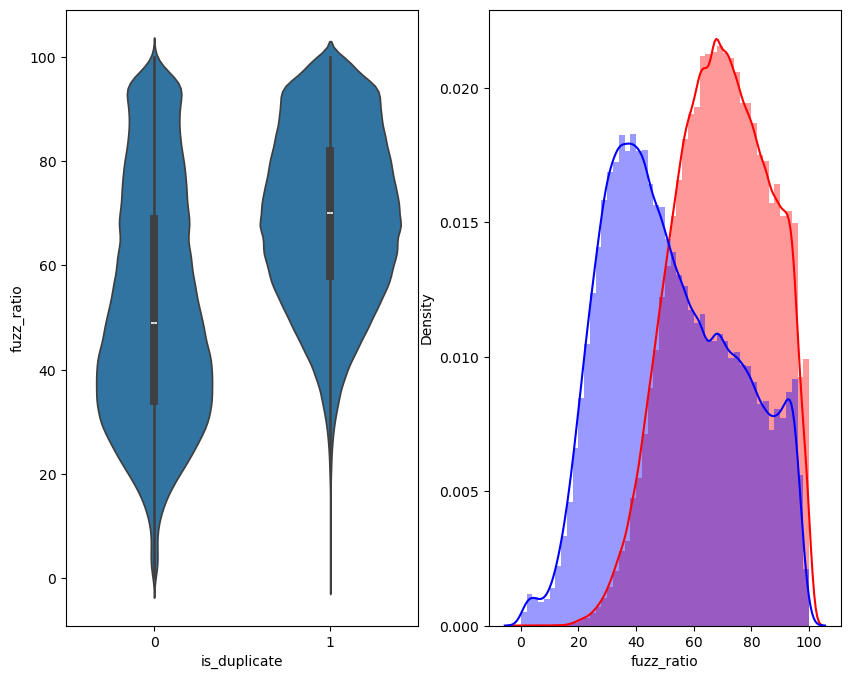

In [49]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<h2>Visualization

In [50]:
# ------------------------------------------------------------
# Prepare features for 3D t-SNE visualization
# ------------------------------------------------------------

from sklearn.preprocessing import MinMaxScaler

# Subsample dataset to 5,000 rows
# t-SNE is extremely slow on large datasets
dfp_subsampled = df[0:5000]

# ------------------------------------------------------------
# Select the 15 engineered features for dimensionality reduction:
#   Token-based features      : cwc_min, cwc_max, csc_min, csc_max,
#                               ctc_min, ctc_max
#   Structural features       : last_word_eq, first_word_eq,
#                               abs_len_diff, mean_len
#   Fuzzy string features     : token_set_ratio, token_sort_ratio,
#                               fuzz_ratio, fuzz_partial_ratio
#   Longest substring feature : longest_substr_ratio
#
# These features describe similarity between a question pair.
# ------------------------------------------------------------
feature_cols = [
    'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
    'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
    'token_set_ratio', 'token_sort_ratio',
    'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio'
]

# ------------------------------------------------------------
# Normalize all feature values to [0, 1]
# t-SNE works BEST when features are scaled evenly.
# MinMaxScaler preserves the shape of distributions while rescaling.
# ------------------------------------------------------------
X = MinMaxScaler().fit_transform(
    dfp_subsampled[feature_cols]
)

# Target labels (1 = duplicate, 0 = non-duplicate)
y = dfp_subsampled['is_duplicate'].values


In [51]:
# ------------------------------------------------------------
# Apply t-SNE to reduce 15-dimensional feature space to 2D
# ------------------------------------------------------------
#
# Why t-SNE?
#  - Captures non-linear structure in high-dimensional similarity features
#  - Reveals clustering patterns for duplicate vs non-duplicate pairs
#  - Much better than PCA for visualization of complex text features
#
# Parameter explanation:
#   n_components = 2     → project data into 2D for visualization
#   init = 'random'      → t-SNE starts from random initialization
#   random_state = 101   → ensures reproducibility of the visualization
#   method = 'barnes_hut'→ optimized algorithm for large datasets
#   n_iter = 1000        → recommended number of optimization steps
#   angle = 0.5          → tradeoff between speed and accuracy
#   verbose = 2          → prints progress during optimization
#
# t-SNE is sensitive to scaling → we already applied MinMaxScaler above.
# ------------------------------------------------------------

tsne2d = TSNE(
    n_components=2,
    init='random',
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.016s...
[t-SNE] Computed neighbors for 5000 samples in 0.589s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.154s
[t-SNE] Iteration 50: error = 85.6682434, gradient norm = 0.0849454 (50 iterations in 1.970s)
[t-SNE] Iteration 100: error = 70.9588013, gradient norm = 0.0138677 (50 iterations in 1.835s)
[t-SNE] Iteration 150: error = 68.9887466, gradient norm = 0.0080579 (50 iterations in 1.787s)
[t-SNE] Iteration 200: error = 68.1129150, gradient norm = 0.0054156 (50 iterations in 1.491s)
[t-SNE] Iteration 250: error = 67.5682373, gradient norm = 0.0042011

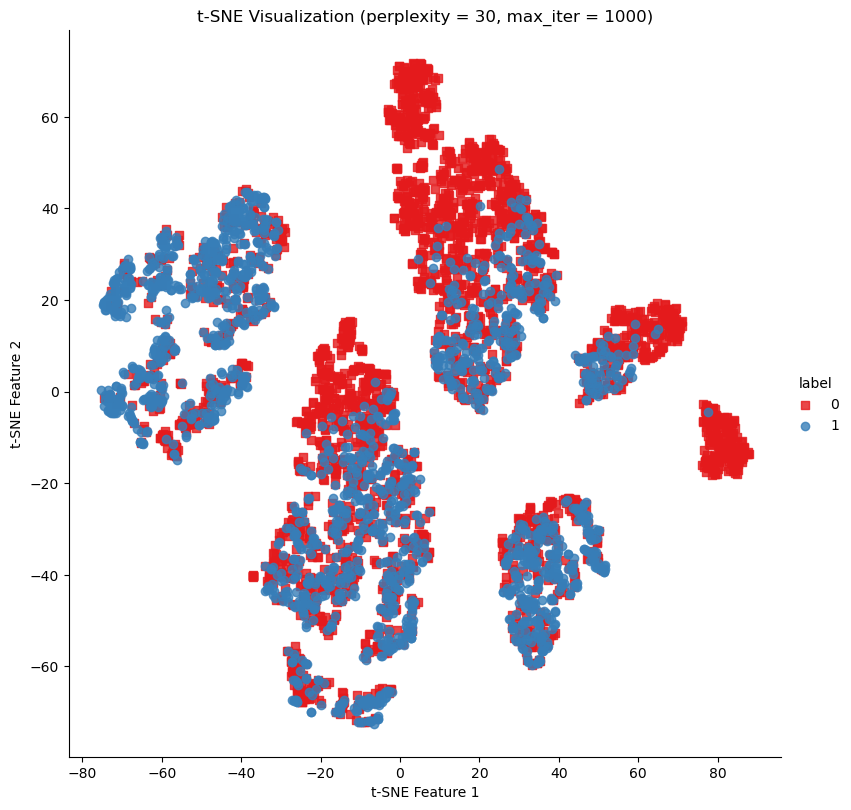

In [52]:
# ------------------------------------------------------------
# Prepare a DataFrame for visualization
# ------------------------------------------------------------
# tsne2d[:,0] → x-axis values
# tsne2d[:,1] → y-axis values
# y           → class label (0 = non-duplicate, 1 = duplicate)
df = pd.DataFrame({
    'x': tsne2d[:, 0],
    'y': tsne2d[:, 1],
    'label': y
})

# ------------------------------------------------------------
# Scatterplot of t-SNE embeddings
# ------------------------------------------------------------
# lmplot:
#   - fit_reg=False → disables regression line
#   - hue='label'   → colors points by class (duplicate vs non-duplicate)
#   - palette       → color scheme
#   - markers       → shapes for each class
#
# Interpretation:
#   - If clusters form clearly → features are good at separating classes
#   - If red and blue overlap heavily → classes are hard to separate
# ------------------------------------------------------------
sns.lmplot(
    data=df,
    x='x', y='y',
    hue='label',
    fit_reg=False,
    height=8,
    palette="Set1",
    markers=['s', 'o']
)

plt.title("t-SNE Visualization (perplexity = 30, max_iter = 1000)")
plt.xlabel("t-SNE Feature 1")
plt.ylabel("t-SNE Feature 2")
plt.show()


In [53]:
# ------------------------------------------------------------
# Apply t-SNE to reduce 15 engineered features into 3D space
# ------------------------------------------------------------
from sklearn.manifold import TSNE

# t-SNE Parameters:
#   n_components = 3     → reduce to 3D for 3D plotting
#   init = 'random'      → random initialization (can also use 'pca')
#   random_state = 101   → reproducible results
#   method = 'barnes_hut'→ optimized algorithm for medium-large datasets
#   n_iter = 1000        → number of optimization iterations
#   angle = 0.5          → speed-quality tradeoff (0.5 recommended)
#   verbose = 2          → prints progress while running
#
# Why 3D t-SNE?
#   - Allows deeper visualization of clusters than 2D
#   - Sometimes reveals separability not visible in 2D projection
# ------------------------------------------------------------

tsne3d = TSNE(
    n_components=3,
    init='random',
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.016s...
[t-SNE] Computed neighbors for 5000 samples in 0.411s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.145s
[t-SNE] Iteration 50: error = 86.2953720, gradient norm = 0.0839511 (50 iterations in 6.535s)
[t-SNE] Iteration 100: error = 69.7087860, gradient norm = 0.0072959 (50 iterations in 3.991s)
[t-SNE] Iteration 150: error = 68.0686035, gradient norm = 0.0036925 (50 iterations in 3.999s)
[t-SNE] Iteration 200: error = 67.4703827, gradient norm = 0.0025236 (50 iterations in 3.781s)
[t-SNE] Iteration 250: error = 67.1370468, gradient norm = 0.0019391

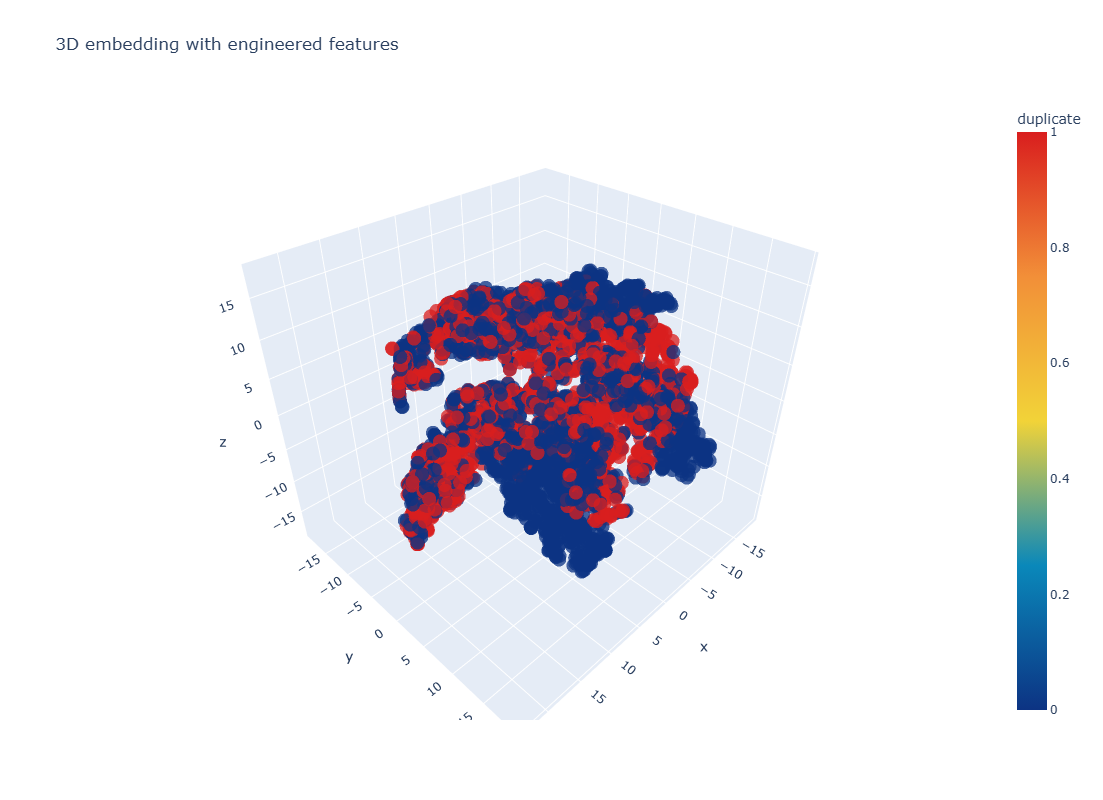

In [55]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],              # t-SNE feature 1
    y=tsne3d[:,1],              # t-SNE feature 2
    z=tsne3d[:,2],              # t-SNE feature 3
    mode='markers',             # show points
    marker=dict(
        sizemode='diameter',    # marker size based on diameter (default)
        color = y,              # color depends on label (duplicate = 1, non-duplicate = 0)
        colorscale = 'Portland',# choose nice color scale
        colorbar = dict(title='duplicate'), # legend for label
        line=dict(color='rgb(255, 255, 255)'), # white outline around dots
        opacity=0.75            # transparency
    )
)

data = [trace1]

# Layout settings for the figure
layout = dict(
    height=800,
    width=800,
    title='3D embedding with engineered features'
)

# Combine data + layout
fig = dict(data=data, layout=layout)

# Render interactive plot
py.iplot(fig, filename='3DBubble')
